In [2]:
""" ImageBind
"""
import data
import torch
from models import imagebind_model
from models.imagebind_model import ModalityType

text_list=["A dog.", "A car", "A bird"]
image_paths=["ImageBind/.assets/dog_image.jpg", "ImageBind/.assets/car_image.jpg", "ImageBind/.assets/bird_image.jpg"]
audio_paths=["ImageBind/.assets/dog_audio.wav", "ImageBind/.assets/car_audio.wav", "ImageBind/.assets/bird_audio.wav",
             "ImageBind/.assets/water_audio.wav", "ImageBind/.assets/phone_audio.wav",]

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge_pth(pretrained=True, pth_path="ImageBind/.checkpoints/imagebind_huge.pth")
model.eval()
model.to(device)

# Load data
inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, device),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, device),
}

with torch.no_grad():
    embeddings = model(inputs)

print(
    "Vision x Text: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
print(
    "Audio x Text: ",
    torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1),
)
print(
    "Vision x Audio: ",
    torch.softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, dim=-1),
)


/home/aiops/xuxy/anaconda3/envs/imagebind/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aiops/xuxy/anaconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/aiops/xuxy/anaconda3/envs/imagebind/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


Vision x Text:  tensor([[9.9763e-01, 2.3512e-03, 1.8975e-05],
        [3.3908e-05, 9.9994e-01, 2.3960e-05],
        [4.7818e-05, 1.3439e-02, 9.8651e-01]], device='cuda:0')
Audio x Text:  tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [6.3984e-20, 7.0275e-42, 1.0000e+00],
        [1.4013e-45, 1.0000e+00, 2.9303e-23]], device='cuda:0')
Vision x Audio:  tensor([[0.7288, 0.0986, 0.0761, 0.0078, 0.0888],
        [0.0839, 0.6415, 0.0871, 0.0167, 0.1708],
        [0.0018, 0.0022, 0.9930, 0.0013, 0.0017]], device='cuda:0')


In [10]:
""" StableDiffusion
"""
from easydict import EasyDict
from omegaconf import OmegaConf

from ldm.models.diffusion.ddpm import ImageEmbeddingConditionedLatentDiffusion
from ldm.models.diffusion.ddim import DDIMSampler

opt = EasyDict(config = 'stablediffusion/configs/stable-diffusion/v2-1-stable-unclip-h-inference.yaml',
               device = 'cuda',
               ckpt = 'stablediffusion/checkpoints/sd21-unclip-h.ckpt',
               C = 4,
               H = 768,
               W = 768,
               f = 8,
               steps = 50, 
               n_samples = 1,
               scale = 20,
               ddim_eta = 0,
               )

config = OmegaConf.load(f"{opt.config}")
pl_sd = torch.load(opt.ckpt, map_location="cpu")
sd = pl_sd["state_dict"]
model = ImageEmbeddingConditionedLatentDiffusion(**config.model['params'])
model.load_state_dict(sd, strict=False)
model.to(opt.device)
model.eval()

sampler = DDIMSampler(model, device=opt.device)

ImageEmbeddingConditionedLatentDiffusion: Running in v-prediction mode
DiffusionWrapper has 870.17 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [11]:
import PIL
from PIL import Image
import numpy as np
def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 64, (w, h))  # resize to integer multiple of 64
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.

In [23]:

shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
batch_size = 1
start_code = None

prompts = ['',] 
c_adm = embeddings[ModalityType.AUDIO][0:1]

mode = "editing"
init_img = 'sketch_bird.jpg'
strength = .7
t_enc = int(strength * opt.steps)

if mode == "editing":
    sampler.make_schedule(ddim_num_steps=opt.steps, ddim_eta=opt.ddim_eta, verbose=False)


with torch.no_grad(), torch.autocast('cuda'):
    c_adm, noise_level_emb = model.noise_augmentor(c_adm, noise_level=torch.zeros(batch_size).long().to(c_adm.device))
    # assume this gives embeddings of noise levels
    c_adm = torch.cat((c_adm, noise_level_emb), 1)

    uc = model.get_learned_conditioning(batch_size * [""])
    uc = {"c_crossattn": [uc], "c_adm": torch.zeros_like(c_adm)}
    c = {"c_crossattn": [model.get_learned_conditioning(prompts)], "c_adm": c_adm}

    if mode == "editing":
        init_image = load_img(init_img).to(device)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space
        z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc] * batch_size).to(device))

        # decode it
        samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                unconditional_conditioning=uc, )
    else:
        samples, _ = sampler.sample(S=opt.steps,
                                    conditioning=c,
                                    batch_size=opt.n_samples,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=opt.scale,
                                    unconditional_conditioning=uc,
                                    eta=opt.ddim_eta,
                                    x_T=start_code)

x_samples = model.decode_first_stage(samples)
x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)


loaded input image of size (850, 637) from sketch_bird.jpg
Running DDIM Sampling with 35 timesteps


Decoding image: 100%|██████████| 35/35 [00:04<00:00,  7.54it/s]


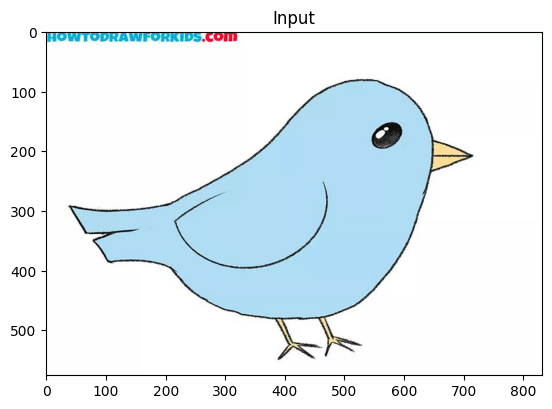

Text(0.5, 1.0, 'Output')

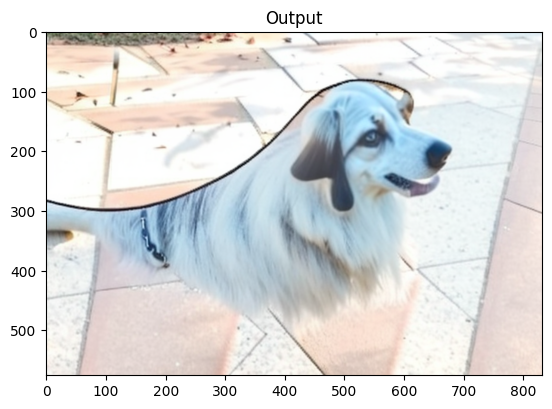

In [24]:
import matplotlib.pyplot as plt

plt.imshow((init_image[0].permute(1,2,0).cpu().float().numpy()+1)/2)
plt.title('Input')
plt.show()

plt.imshow(x_samples[0].permute(1,2,0).cpu().float().numpy())
plt.title('Output')